In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data exploratory

In [89]:
use_cols=[
    'espvida',
    'pop',
    'i_escolaridade',
    'data_publicacao',
    'data_inicio_sintomas',
    'sexo',
    'obito',
    'idade',
    'idhm',
    't_agua',
    't_lixo',
    't_luz',
    'agua_esgoto',
    'p_med',
    'cod_ibge',
    'município'
]

In [90]:
df = pd.read_csv('../output/01_covid_idh.csv' )
df = df[use_cols]

Columns (6,40) have mixed types. Specify dtype option on import or set low_memory=False.


In [91]:
print('Data shape: ', df.shape)


Data shape:  (1666760, 16)


In [92]:
df_aux = pd.DataFrame(
    {
        'column': df.columns,
        'dtype': df.dtypes,
        'nulls': df.isnull().sum(),
        'null_pct': df.isnull().sum() / df.shape[0]
    }
).sort_values('null_pct', ascending=False)

In [93]:
df_aux

,column,dtype,nulls,null_pct
idade,idade,float64,259,0.000155
espvida,espvida,float64,0,0.000000
pop,pop,int64,0,0.000000
i_escolaridade,i_escolaridade,float64,0,0.000000
data_publicacao,data_publicacao,object,0,0.000000
data_inicio_sintomas,data_inicio_sintomas,object,0,0.000000
sexo,sexo,object,0,0.000000
obito,obito,object,0,0.000000
idhm,idhm,float64,0,0.000000
t_agua,t_agua,float64,0,0.000000


In [94]:
list_columns_out = df_aux.loc[df_aux.null_pct > 0.25].index.to_list()

In [95]:
df.drop(columns=list_columns_out, inplace=True)

In [96]:
df.nunique()

espvida                 190
pop                     290
i_escolaridade          200
data_publicacao           1
data_inicio_sintomas    763
sexo                      3
obito                     2
idade                   121
idhm                    137
t_agua                  277
t_lixo                  184
t_luz                    95
agua_esgoto             166
p_med                   276
cod_ibge                293
município               293
dtype: int64

In [97]:
for col in df.columns:
    if df[col].nunique()==1:
        print('Drop column: ', col)
        df.drop(columns=col, inplace=True)

Drop column:  data_publicacao


In [98]:
df_aux = pd.DataFrame(
    {
        'column': df.columns,
        'dtype': df.dtypes,
        'nulls': df.isnull().sum(),
        'null_pct': df.isnull().sum() / df.shape[0]
    }
).sort_values('null_pct', ascending=False)

In [99]:
df_aux.loc[df_aux.dtype == 'object'].column.to_list()

['data_inicio_sintomas', 'sexo', 'obito', 'município']

In [100]:
df_aux.head()

,column,dtype,nulls,null_pct
idade,idade,float64,259,0.000155
espvida,espvida,float64,0,0.000000
pop,pop,int64,0,0.000000
i_escolaridade,i_escolaridade,float64,0,0.000000
data_inicio_sintomas,data_inicio_sintomas,object,0,0.000000


## Data Preparation

In [101]:
def transform_date(df, col_list):
    for col in col_list:
        df[col] = pd.to_datetime(df[col])
    return df

In [102]:
df = transform_date(df, ['data_inicio_sintomas'])

### FillNa

In [103]:
df['idade'] = df.idade.fillna(df.idade.mean())


### Features Creation

In [104]:
df['ageGroup'] = pd.cut(
    df.idade,
    bins=[0,20, 40, 60, sys.maxsize],
    labels=['<20', '20-40', '40-60', '>60']
)
df['percAgeEsp'] = df.idade/df.espvida


In [105]:
_temp = pd.DataFrame(df.groupby('data_inicio_sintomas')['espvida'].count()).reset_index()
_temp.columns= ['data_inicio_sintomas','Casos']
df = pd.merge(df, _temp, on='data_inicio_sintomas')

In [106]:
df['casos_per_pop'] = df.Casos*1000/(df['pop'])

{
    'percAgeEsp': 'Porcentagem de idade do estado em relação ao total de idade da população',
    'ageGroup': 'Faixa etária',
    'casos_per_pop': 'Casos por população'
}

## Pandas profiling

In [107]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df, title="Profile Report Covid-19", html={'style':{'full_width':True}})
#profile.to_file("output.html")

## Export data

In [108]:
_temp = df.loc[df.obito=='SIM'].groupby('cod_ibge').count()['obito'].reset_index()
_temp.columns= ['cod_ibge','obitos_por_mun']
df = pd.merge(df, _temp, on='cod_ibge')

In [109]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,sexo,obito,idade,idhm,t_agua,t_lixo,t_luz,agua_esgoto,p_med,cod_ibge,município,ageGroup,percAgeEsp,Casos,casos_per_pop,obitos_por_mun
0,78.64,306393,0.659,2022-02-22,MASCULINO,NAO,36.0,0.806,97.89,99.88,99.97,0.5,49.58,4202404,BLUMENAU,20-40,0.457782,2029,6.622214,769
1,78.64,306393,0.659,2022-02-22,MASCULINO,NAO,40.0,0.806,97.89,99.88,99.97,0.5,49.58,4202404,BLUMENAU,20-40,0.508647,2029,6.622214,769
2,78.64,306393,0.659,2022-02-22,MASCULINO,NAO,27.0,0.806,97.89,99.88,99.97,0.5,49.58,4202404,BLUMENAU,20-40,0.343337,2029,6.622214,769
3,78.64,306393,0.659,2022-02-22,MASCULINO,NAO,6.0,0.806,97.89,99.88,99.97,0.5,49.58,4202404,BLUMENAU,<20,0.076297,2029,6.622214,769
4,78.64,306393,0.659,2022-02-22,MASCULINO,NAO,37.0,0.806,97.89,99.88,99.97,0.5,49.58,4202404,BLUMENAU,20-40,0.470498,2029,6.622214,769


In [110]:
df['obitos_per_1k_pop'] = df.obitos_por_mun*1000/(df['pop'])

In [111]:
#drop duplicates
df[['cod_ibge','obitos_per_1k_pop']].drop_duplicates().to_csv('../output/pbi_obitos_mun.csv', index=False)

In [112]:
df.to_csv('../output/saida_pbi.csv', index=False)

### Encoding data

In [113]:
from sklearn.preprocessing import LabelEncoder


In [114]:
df_aux.loc[df_aux.dtype == 'object']
for col in df_aux.loc[df_aux.dtype == 'object'].column.to_list():
    df[col] = df[col].astype('category')
list_cat_columns = df_aux.loc[df_aux.dtype == 'object'].column.tolist()

lbl = LabelEncoder()
for col in list_cat_columns:
    column_name = 'enc_{}'.format(col)
    df[column_name] = lbl.fit_transform(df[col])

### Fill NaN and Fill sexo feature

In [115]:
df['sexo'].value_counts()

FEMININO         884219
MASCULINO        782224
NAO INFORMADO        32
Name: sexo, dtype: int64

### One Hot Encoding

In [116]:
#Dumies
df = pd.concat([df,pd.get_dummies(df.enc_sexo,drop_first=True,prefix='enc_sexo')], axis=1)
#df = pd.concat([df,pd.get_dummies(df.regional_saude,drop_first=True,prefix='regional_saude')], axis=1)
df = pd.concat([df,pd.get_dummies(df.ageGroup,drop_first=True,prefix='ageGroup')], axis=1)
df.drop(['idade','sexo','enc_sexo'], axis=1, inplace=True)

In [117]:
df.to_csv('../output/03_covid_idh_prepared.csv', index=False)

## Data Visualization

In [1]:
import pandas as pd
df = pd.read_csv('../output/03_covid_idh_prepared.csv')

In [2]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,obito,idhm,t_agua,t_lixo,t_luz,agua_esgoto,...,obitos_por_mun,obitos_per_1k_pop,enc_data_inicio_sintomas,enc_obito,enc_município,enc_sexo_1,enc_sexo_2,ageGroup_20-40,ageGroup_40-60,ageGroup_>60
0,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
1,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
2,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
3,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,0,0,0
4,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0


Visalization target variable

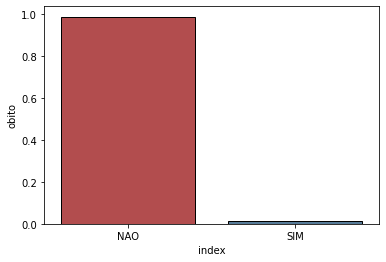

In [4]:
df.obito.value_counts()/df.shape[0]

#Count plot percentage using seaborn
ax = sns.barplot(x='index',y='obito', data=pd.DataFrame(df.obito.value_counts()/df.shape[0]).reset_index(), palette='Set1', saturation=0.5, edgecolor='black')
plt.show()

In [5]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,obito,idhm,t_agua,t_lixo,t_luz,agua_esgoto,...,obitos_por_mun,obitos_per_1k_pop,enc_data_inicio_sintomas,enc_obito,enc_município,enc_sexo_1,enc_sexo_2,ageGroup_20-40,ageGroup_40-60,ageGroup_>60
0,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
1,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
2,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
3,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,0,0,0
4,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0


count    1.666475e+06
mean     7.709223e+01
std      1.304014e+00
min      7.105000e+01
25%      7.655000e+01
50%      7.733000e+01
75%      7.808000e+01
max      7.864000e+01
Name: espvida, dtype: float64


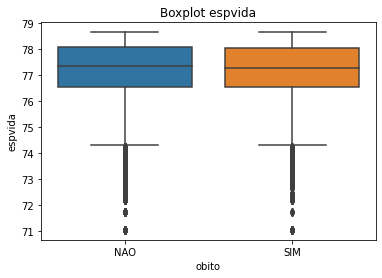

count    1.666475e+06
mean     1.531302e+05
std      1.652209e+05
min      1.465000e+03
25%      2.215700e+04
50%      7.036100e+04
75%      2.086730e+05
max      5.124060e+05
Name: pop, dtype: float64


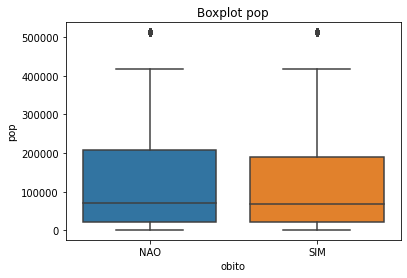

count    1.666475e+06
mean     6.006762e-01
std      1.116029e-01
min      2.640000e-01
25%      5.220000e-01
50%      6.080000e-01
75%      6.870000e-01
max      8.000000e-01
Name: i_escolaridade, dtype: float64


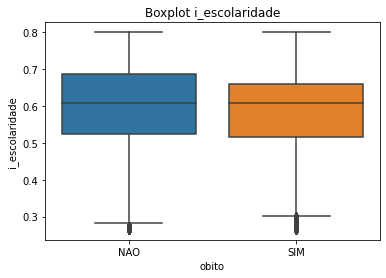

count    1.666475e+06
mean     7.772202e-01
std      4.024872e-02
min      6.210000e-01
25%      7.520000e-01
50%      7.830000e-01
75%      8.060000e-01
max      8.470000e-01
Name: idhm, dtype: float64


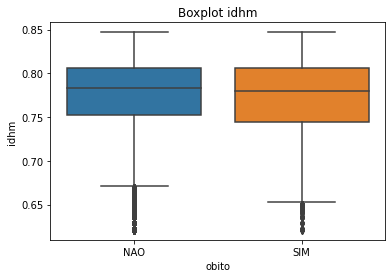

count    1.666475e+06
mean     9.445852e+01
std      5.811846e+00
min      5.195000e+01
25%      9.321000e+01
50%      9.635000e+01
75%      9.789000e+01
max      9.961000e+01
Name: t_agua, dtype: float64


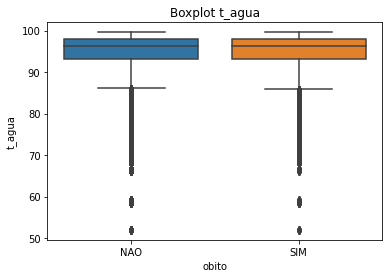

count    1.666475e+06
mean     9.928994e+01
std      1.379071e+00
min      8.085000e+01
25%      9.924000e+01
50%      9.972000e+01
75%      9.988000e+01
max      1.000000e+02
Name: t_lixo, dtype: float64


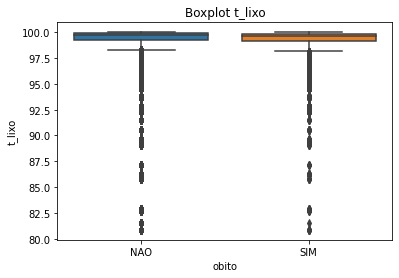

count    1.666475e+06
mean     9.983862e+01
std      3.304803e-01
min      9.418000e+01
25%      9.983000e+01
50%      9.993000e+01
75%      9.997000e+01
max      1.000000e+02
Name: t_luz, dtype: float64


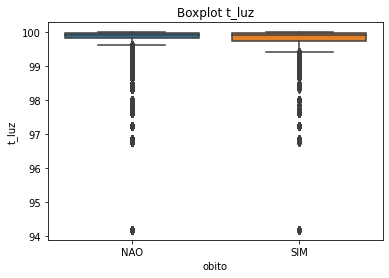

count    1.666475e+06
mean     6.953857e-01
std      1.300163e+00
min      0.000000e+00
25%      1.600000e-01
50%      3.400000e-01
75%      6.500000e-01
max      2.844000e+01
Name: agua_esgoto, dtype: float64


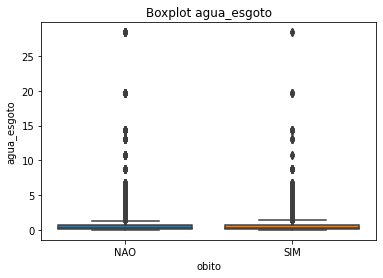

count    1.666475e+06
mean     4.731664e+01
std      1.142541e+01
min      1.602000e+01
25%      3.933000e+01
50%      4.886000e+01
75%      5.396000e+01
max      7.030000e+01
Name: p_med, dtype: float64


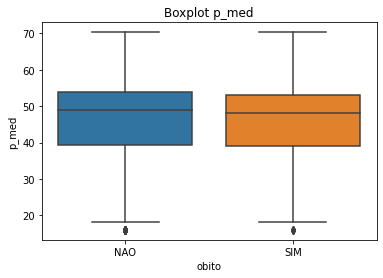

count    1.666475e+06
mean     5.012627e-01
std      2.257416e-01
min      0.000000e+00
25%      3.392484e-01
50%      4.827766e-01
75%      6.510084e-01
max      1.597231e+00
Name: percAgeEsp, dtype: float64


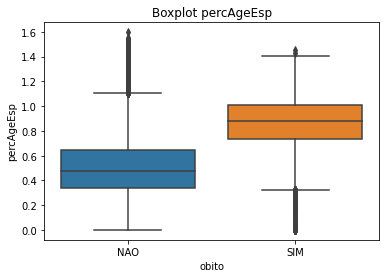

In [6]:
columns = ['espvida', 'pop', 'i_escolaridade', 'idhm', 't_agua', 't_lixo', 't_luz', 'agua_esgoto',
       'p_med', 'percAgeEsp']
for column in columns:
    print(df[column].describe())
    sns.boxplot(y=df[column], x=df['obito'])
    plt.title(f'Boxplot {column}')
    plt.show()

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


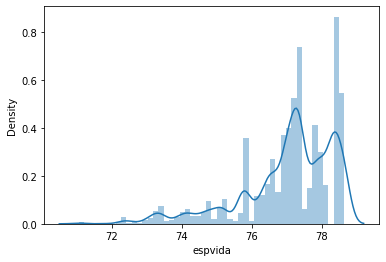

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


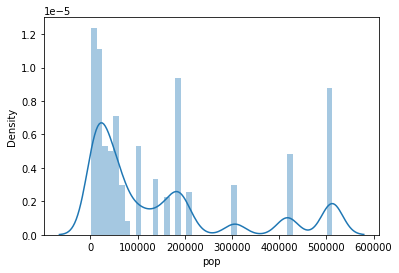

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


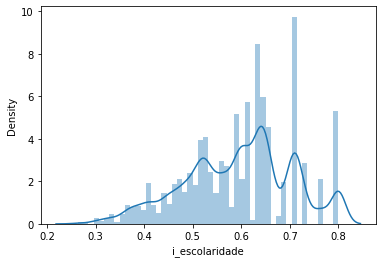

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


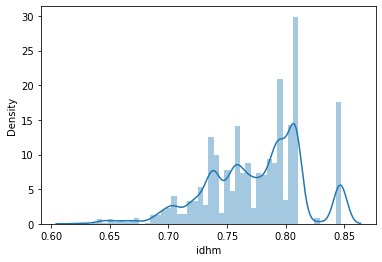

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


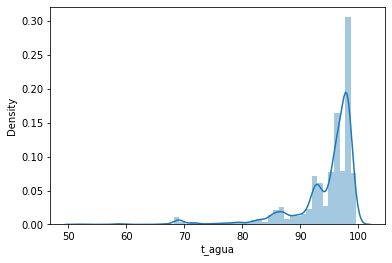

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


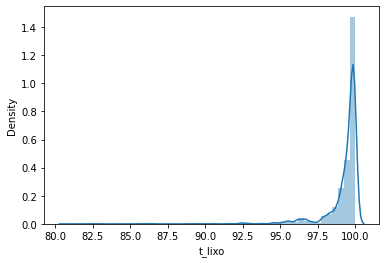

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


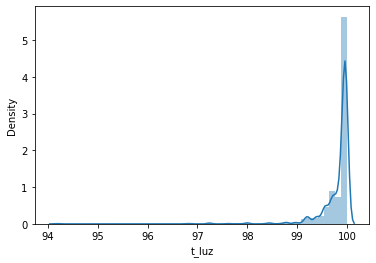

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


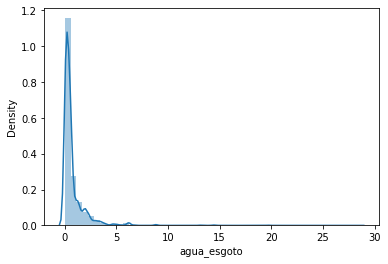

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


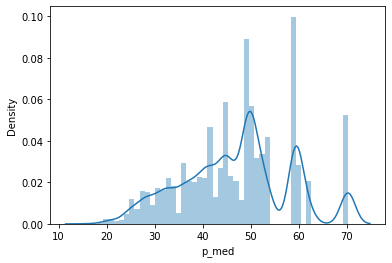

c:\users\cassi\desktop\cassio\06 - puc\tcc_v_final\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


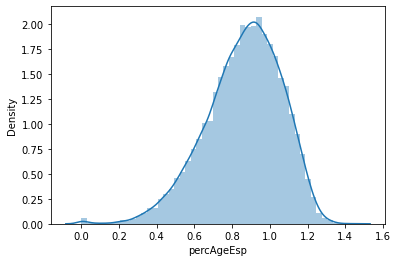

In [7]:
_temp = df.loc[df.obito=='SIM']
for column in columns:
    sns.distplot(
        _temp[column]
    )
    plt.show()

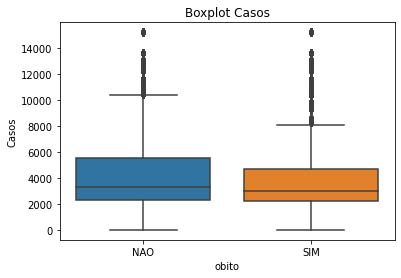

In [8]:
sns.boxplot(y=df['Casos'], x=df['obito'])
plt.title(f'Boxplot Casos')
plt.show()

In [125]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,obito,idhm,t_agua,t_lixo,t_luz,agua_esgoto,...,obitos_por_mun,obitos_per_1k_pop,enc_data_inicio_sintomas,enc_obito,enc_município,enc_sexo_1,enc_sexo_2,ageGroup_20-40,ageGroup_40-60,ageGroup_>60
0,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
1,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
2,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
3,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,0,0,0
4,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0


## Modeling

In [126]:
df = pd.read_csv('../output/03_covid_idh_prepared.csv')

In [127]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,obito,idhm,t_agua,t_lixo,t_luz,agua_esgoto,...,obitos_por_mun,obitos_per_1k_pop,enc_data_inicio_sintomas,enc_obito,enc_município,enc_sexo_1,enc_sexo_2,ageGroup_20-40,ageGroup_40-60,ageGroup_>60
0,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
1,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
2,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0
3,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,0,0,0
4,78.64,306393,0.659,2022-02-22,NAO,0.806,97.89,99.88,99.97,0.5,...,769,2.509848,728,0,33,1,0,1,0,0


In [128]:
df = transform_date(df, ['data_inicio_sintomas'])

In [129]:
df['date'] = pd.to_datetime(df.data_inicio_sintomas)
df['date'] = pd.to_datetime(df.date, infer_datetime_format = True, utc = True).astype('datetime64[ns]')


Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead


In [130]:
df.dtypes

espvida                            float64
pop                                  int64
i_escolaridade                     float64
data_inicio_sintomas        datetime64[ns]
obito                               object
idhm                               float64
t_agua                             float64
t_lixo                             float64
t_luz                              float64
agua_esgoto                        float64
p_med                              float64
cod_ibge                             int64
município                           object
ageGroup                            object
percAgeEsp                         float64
Casos                                int64
casos_per_pop                      float64
obitos_por_mun                       int64
obitos_per_1k_pop                  float64
enc_data_inicio_sintomas             int64
enc_obito                            int64
enc_município                        int64
enc_sexo_1                           int64
enc_sexo_2 

In [131]:
df = df[(df.date >= '2020-01-01') & (df.date <= '2021-05-01')]


### Normalization

In [132]:
from sklearn.preprocessing import MinMaxScaler
from collections import Counter


In [133]:
minMax = MinMaxScaler()


In [134]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,obito,idhm,t_agua,t_lixo,t_luz,agua_esgoto,...,obitos_per_1k_pop,enc_data_inicio_sintomas,enc_obito,enc_município,enc_sexo_1,enc_sexo_2,ageGroup_20-40,ageGroup_40-60,ageGroup_>60,date
73,78.64,306393,0.659,2020-11-09,NAO,0.806,97.89,99.88,99.97,0.5,...,2.509848,258,0,33,0,0,1,0,0,2020-11-09
74,78.64,306393,0.659,2020-11-09,NAO,0.806,97.89,99.88,99.97,0.5,...,2.509848,258,0,33,0,0,1,0,0,2020-11-09
75,78.64,306393,0.659,2020-11-09,NAO,0.806,97.89,99.88,99.97,0.5,...,2.509848,258,0,33,1,0,1,0,0,2020-11-09
76,78.64,306393,0.659,2020-11-09,NAO,0.806,97.89,99.88,99.97,0.5,...,2.509848,258,0,33,1,0,1,0,0,2020-11-09
77,78.64,306393,0.659,2020-11-09,NAO,0.806,97.89,99.88,99.97,0.5,...,2.509848,258,0,33,0,0,0,0,0,2020-11-09


In [135]:
cols = ['espvida',
        'pop',
        'idhm',
        't_agua',
        't_lixo',
        't_luz',
        'p_med',
        'agua_esgoto',
        'percAgeEsp',
        'Casos',
        'casos_per_pop'
        ]

for col in cols:
    df[col] = minMax.fit_transform(df[[col]])

In [136]:
df.head()

,espvida,pop,i_escolaridade,data_inicio_sintomas,obito,idhm,t_agua,t_lixo,t_luz,agua_esgoto,...,obitos_per_1k_pop,enc_data_inicio_sintomas,enc_obito,enc_município,enc_sexo_1,enc_sexo_2,ageGroup_20-40,ageGroup_40-60,ageGroup_>60,date
73,1.0,0.596797,0.659,2020-11-09,NAO,0.818584,0.963911,0.993734,0.994845,0.017581,...,2.509848,258,0,33,0,0,1,0,0,2020-11-09
74,1.0,0.596797,0.659,2020-11-09,NAO,0.818584,0.963911,0.993734,0.994845,0.017581,...,2.509848,258,0,33,0,0,1,0,0,2020-11-09
75,1.0,0.596797,0.659,2020-11-09,NAO,0.818584,0.963911,0.993734,0.994845,0.017581,...,2.509848,258,0,33,1,0,1,0,0,2020-11-09
76,1.0,0.596797,0.659,2020-11-09,NAO,0.818584,0.963911,0.993734,0.994845,0.017581,...,2.509848,258,0,33,1,0,1,0,0,2020-11-09
77,1.0,0.596797,0.659,2020-11-09,NAO,0.818584,0.963911,0.993734,0.994845,0.017581,...,2.509848,258,0,33,0,0,0,0,0,2020-11-09


In [137]:
df.columns

Index(['espvida', 'pop', 'i_escolaridade', 'data_inicio_sintomas', 'obito',
       'idhm', 't_agua', 't_lixo', 't_luz', 'agua_esgoto', 'p_med', 'cod_ibge',
       'município', 'ageGroup', 'percAgeEsp', 'Casos', 'casos_per_pop',
       'obitos_por_mun', 'obitos_per_1k_pop', 'enc_data_inicio_sintomas',
       'enc_obito', 'enc_município', 'enc_sexo_1', 'enc_sexo_2',
       'ageGroup_20-40', 'ageGroup_40-60', 'ageGroup_>60', 'date'],
      dtype='object')

In [138]:
use_cols_X = ['i_escolaridade', 'idhm', 't_agua', 't_lixo', 't_luz', 'agua_esgoto', 'p_med',
       'percAgeEsp',  'enc_sexo_1', 'enc_sexo_2','casos_per_pop']
use_cols_y = ['enc_obito']

### Undersampling

In [139]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [140]:
df_X = df[use_cols_X]
df_Y = df[use_cols_y]

rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(df_X, df_Y)


## Running models

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn import metrics


In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [143]:
def running_models(X_train, X_test, y_train, y_test):
    lg_class=LogisticRegression()
    kn_class = KNeighborsClassifier()
    ad_class = AdaBoostClassifier()
    xg_class = XGBClassifier()
    gbc_class = GradientBoostingClassifier()
    rf_class = RandomForestClassifier()
    models = [lg_class,kn_class,ad_class,xg_class,gbc_class, rf_class]

    for model in models:
        print(model)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(metrics.classification_report(y_true=y_test, y_pred=y_pred))
        y_pred_proba = model.predict_proba(X_test)
        pos_proba = y_pred_proba[:, 1]
        print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))
        print('*********************************************************\n\n')
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
        plt.plot(fpr, tpr, '*-')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend(['ROC curve', 'Random classifier'])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.show()


LogisticRegression()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3059
           1       0.81      0.83      0.82      2994

    accuracy                           0.82      6053
   macro avg       0.82      0.82      0.82      6053
weighted avg       0.82      0.82      0.82      6053

The AUC Score is:  0.8937031740281258
*********************************************************




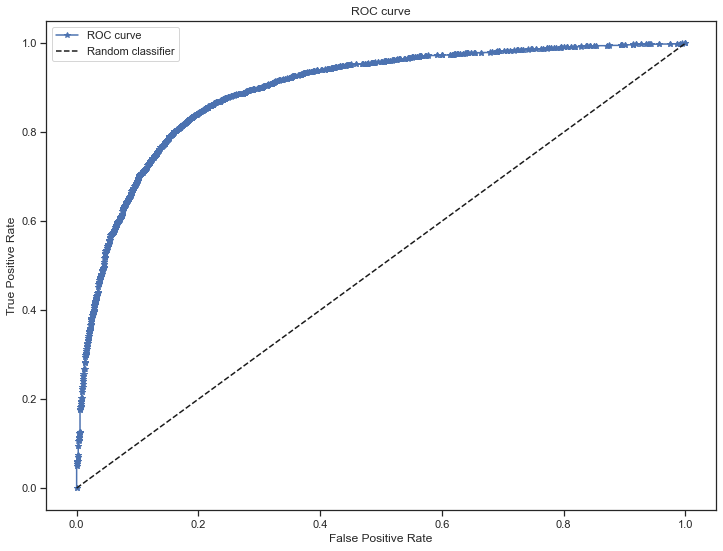

KNeighborsClassifier()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3059
           1       0.79      0.80      0.79      2994

    accuracy                           0.79      6053
   macro avg       0.79      0.79      0.79      6053
weighted avg       0.79      0.79      0.79      6053

The AUC Score is:  0.8558308728167897
*********************************************************




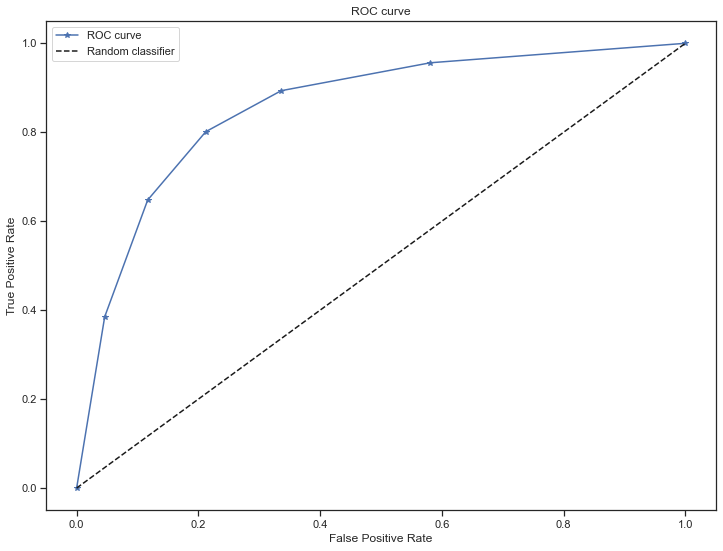

AdaBoostClassifier()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3059
           1       0.82      0.82      0.82      2994

    accuracy                           0.82      6053
   macro avg       0.82      0.82      0.82      6053
weighted avg       0.82      0.82      0.82      6053

The AUC Score is:  0.8917093749447245
*********************************************************




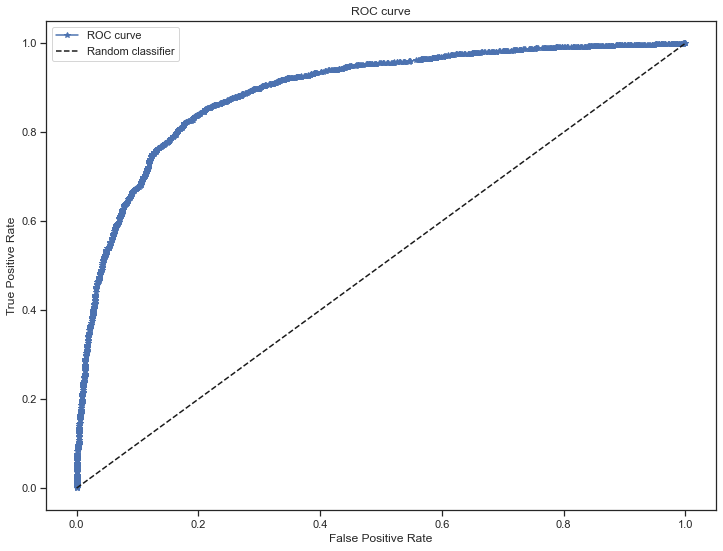

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      3059
           1       0.81      0.82      0.82      2994

    accuracy                           0.82      6053
   macro avg       0.82      0.82      0.

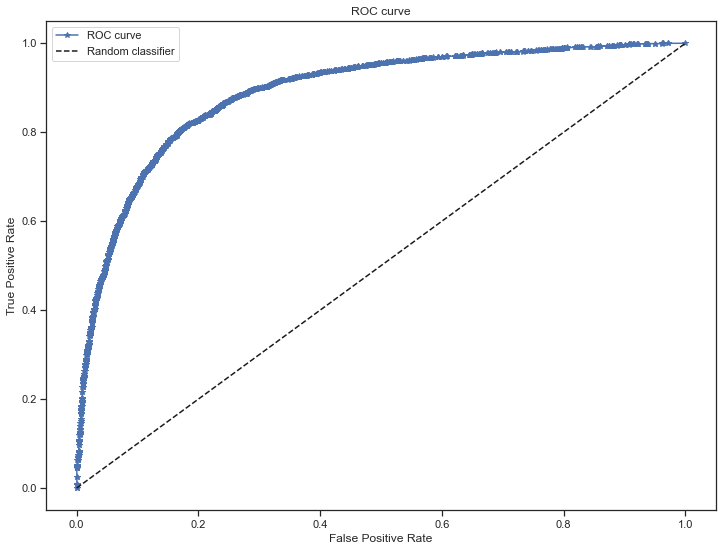

GradientBoostingClassifier()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3059
           1       0.82      0.82      0.82      2994

    accuracy                           0.82      6053
   macro avg       0.82      0.82      0.82      6053
weighted avg       0.82      0.82      0.82      6053

The AUC Score is:  0.8950998324424811
*********************************************************




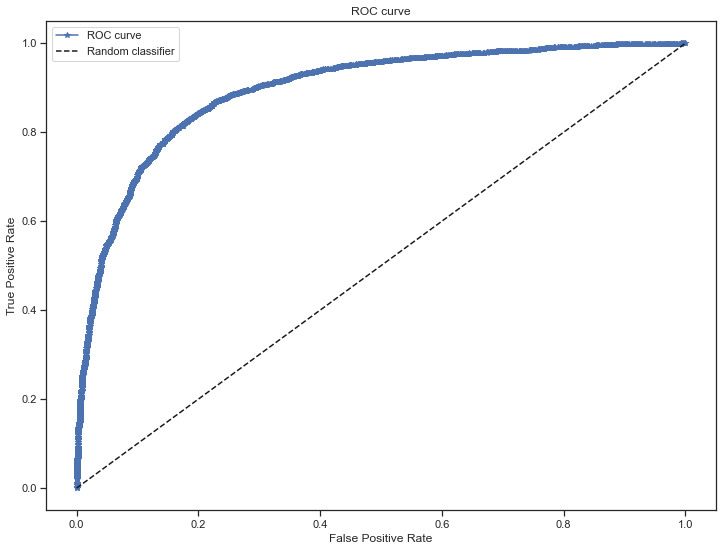

RandomForestClassifier()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.79      0.78      0.79      3059
           1       0.78      0.79      0.79      2994

    accuracy                           0.79      6053
   macro avg       0.79      0.79      0.79      6053
weighted avg       0.79      0.79      0.79      6053

The AUC Score is:  0.8608969600965033
*********************************************************




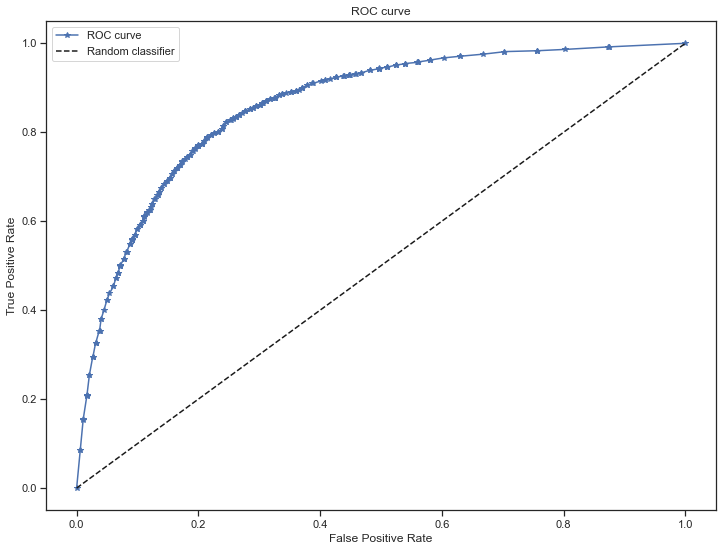

In [144]:
running_models(X_train, X_test, y_train, y_test)

### XGB: GridSearchCV e Cross-Validation

In [145]:
from sklearn.model_selection import GridSearchCV


In [146]:
cv = GridSearchCV(XGBClassifier(),
                  param_grid={'max_depth': [3, 5, 7],
                              'n_estimators': [50, 100, 200],
                              'learning_rate': [0.1, 0.3, 0.5]},
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1)

In [147]:
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [148]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df.sort_values(by='rank_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,3.585470,0.081846,0.034376,6.249500e-03,0.5,7,200,"{'learning_rate': 0.5, 'max_depth': 7, 'n_esti...",0.869689,0.871267,0.870117,0.864073,0.867987,0.868627,0.002509,27
23,2.568750,0.025388,0.025000,7.654266e-03,0.5,5,200,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.875001,0.875978,0.876212,0.869182,0.875116,0.874298,0.002601,26
25,1.869575,0.021500,0.015625,3.814697e-07,0.5,7,100,"{'learning_rate': 0.5, 'max_depth': 7, 'n_esti...",0.878371,0.878283,0.876540,0.869334,0.872579,0.875022,0.003535,25
17,3.671254,0.020127,0.037500,7.654461e-03,0.3,7,200,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",0.878034,0.881442,0.876325,0.872037,0.875909,0.876750,0.003058,24
24,0.984375,0.017117,0.015625,2.780415e-07,0.5,7,50,"{'learning_rate': 0.5, 'max_depth': 7, 'n_esti...",0.883965,0.883983,0.880251,0.876174,0.877153,0.880305,0.003284,23
22,1.300001,0.011692,0.018750,6.249452e-03,0.5,5,100,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.882159,0.882231,0.882982,0.875553,0.879069,0.880399,0.002770,22
16,1.909436,0.007238,0.018750,6.250644e-03,0.3,7,100,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",0.885180,0.885662,0.880876,0.876832,0.880990,0.881908,0.003239,21
14,2.575599,0.020838,0.025045,2.504015e-03,0.3,5,200,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",0.886962,0.884098,0.884854,0.876602,0.883253,0.883154,0.003499,20
20,1.573696,0.027386,0.015625,1.007019e-06,0.5,3,200,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",0.888562,0.885238,0.885157,0.879909,0.884601,0.884693,0.002770,19
15,1.004797,0.009659,0.013600,4.900377e-04,0.3,7,50,"{'learning_rate': 0.3, 'max_depth': 7, 'n_esti...",0.888619,0.888535,0.884206,0.881372,0.884075,0.885361,0.002814,18


In [149]:
cv.best_params_


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [150]:
features_importance = pd.DataFrame(cv.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

In [151]:
features_importance

,importance
percAgeEsp,0.752249
enc_sexo_1,0.064229
agua_esgoto,0.035301
i_escolaridade,0.029436
idhm,0.022055
casos_per_pop,0.021268
t_agua,0.021009
p_med,0.020960
t_luz,0.017189
t_lixo,0.016304


In [152]:
xgreg = XGBClassifier(
   learning_rate= 0.1,
    max_depth= 3,
    n_estimators= 100
)

In [153]:
xgreg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [154]:
y_pred = xgreg.predict(X_test)

In [155]:
print('The accuracy model:', metrics.accuracy_score(y_test, y_pred))

The accuracy model: 0.8224021146538907


In [156]:
metrics.confusion_matrix(y_test, y_pred)

array([[2514,  545],
       [ 530, 2464]], dtype=int64)

In [157]:
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3059
           1       0.82      0.82      0.82      2994

    accuracy                           0.82      6053
   macro avg       0.82      0.82      0.82      6053
weighted avg       0.82      0.82      0.82      6053



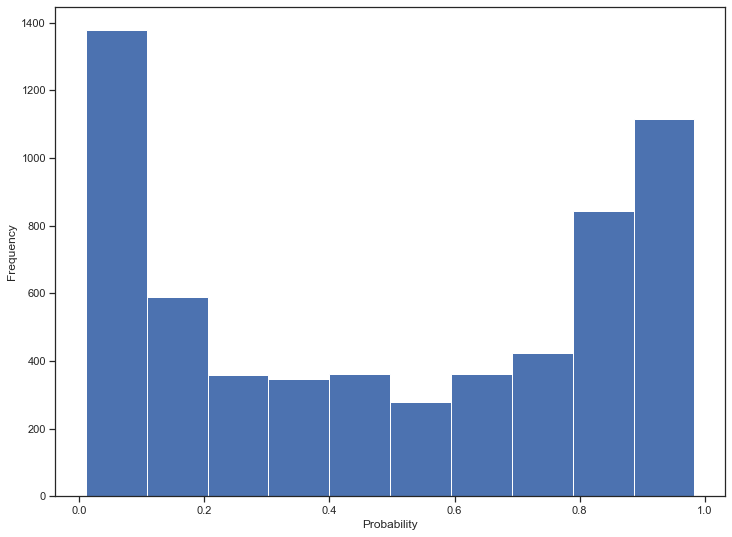

In [158]:
y_pred_proba = xgreg.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]

plt.hist(pos_proba)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

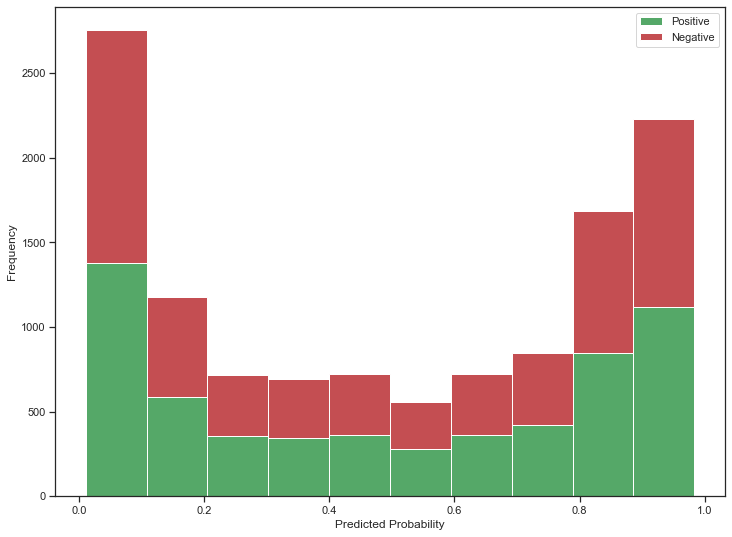

In [159]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test==1).reset_index()['enc_obito'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test==0).reset_index()['enc_obito'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])
plt.show()

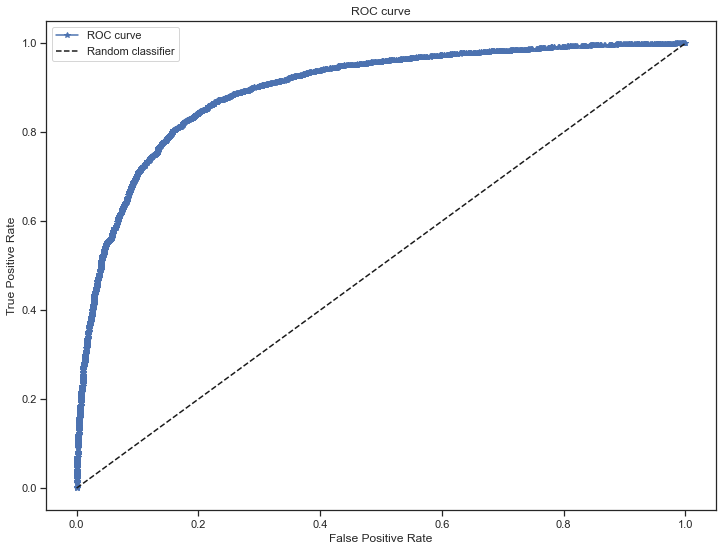

In [160]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

(0.0, 1.0)

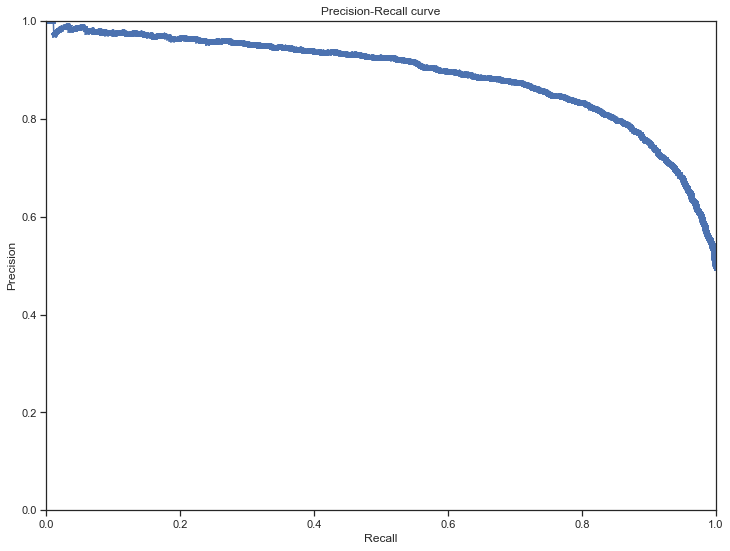

In [161]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [162]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))



The area under the precision-recall curve is: 0.8899427370464663
The threshold for the model is 0.9832983613014221
The probability for the model is False
The AUC Score is:  0.89559897827692


### Feature Importance

In [163]:
import shap


In [164]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')
shap.initjs()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


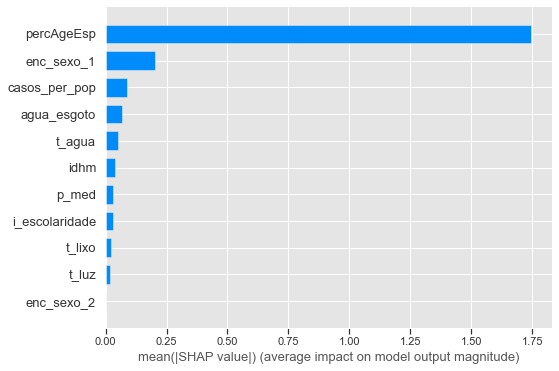

In [165]:
shap_values = shap.TreeExplainer(xgreg).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [166]:
X_importance = X_test
explainer = shap.TreeExplainer(xgreg)
shap_values = explainer.shap_values(X_importance)

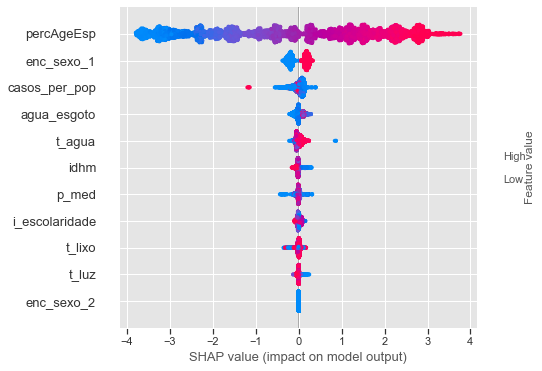

In [167]:
shap.summary_plot(shap_values, X_importance)